In [2]:
import torch
print(torch.cuda.is_available())

import os
from datasets import load_dataset
from PIL import Image
import clip
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import data_utils
from torchvision import transforms
import similarity
import utils
import datetime
import pandas as pd
import json


False


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
PM_SUFFIX = {"max":"_max", "avg":""}

def _make_save_dir(save_name):
    """
    creates save directory if one does not exist
    save_name: full save path
    """
    save_dir = save_name[:save_name.rfind("/")]
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    return



def get_save_names(clip_name, target_name, target_layer, d_probe, concept_set, pool_mode, save_dir):
    
    target_save_name = "{}/{}_{}_{}{}.pt".format(save_dir, d_probe, target_name, target_layer,
                                             PM_SUFFIX[pool_mode])
    clip_save_name = "{}/{}_{}.pt".format(save_dir, d_probe, clip_name.replace('/', ''))
    concept_set_name = (concept_set.split("/")[-1]).split(".")[0]
    text_save_name = "{}/{}_{}.pt".format(save_dir, concept_set_name, clip_name.replace('/', ''))
    
    return target_save_name, clip_save_name, text_save_name
    

In [4]:
def save_clip_image_features(model, dataset, save_name, batch_size=1000 , device = "mps"):
    _make_save_dir(save_name)
    
    all_features = []
    
    if os.path.exists(save_name):
        return
    
    save_dir = save_name[:save_name.rfind("/")]
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    try:
        with torch.no_grad():
            for images in tqdm(DataLoader(dataset, batch_size, num_workers=8, pin_memory=True)):
                features = model.encode_image(images.to(device))
                all_features.append(features)
    
    except:
        print("Couldn't do for images in tqdm(Dataloader)")
        with torch.no_grad():
            for images, labels in tqdm(DataLoader(dataset, batch_size, num_workers=8, pin_memory=True)):
                features = model.encode_image(images.to(device))
                all_features.append(features)
    torch.save(torch.cat(all_features), save_name)
    #free memory
    del all_features
    torch.cuda.empty_cache()
    return


In [5]:
def save_target_activations(target_model, dataset, save_name, target_layers = ["layer4"], batch_size = 1000,
                            device = "cuda", pool_mode='avg'):
    """
    save_name: save_file path, should include {} which will be formatted by layer names
    """
    _make_save_dir(save_name)
    save_names = {}    
    for target_layer in target_layers:
        save_names[target_layer] = save_name.format(target_layer)
        
    if _all_saved(save_names):
        return
    
    all_features = {target_layer:[] for target_layer in target_layers}
    
    hooks = {}
    for target_layer in target_layers:
        command = "target_model.{}.register_forward_hook(get_activation(all_features[target_layer], pool_mode))".format(target_layer)
        hooks[target_layer] = eval(command)
    
    try:
        with torch.no_grad():
            for images in tqdm(DataLoader(dataset, batch_size, num_workers=8, pin_memory=True)):
                features = target_model(images.to(device))
    except:
        with torch.no_grad():
            for images, labels in tqdm(DataLoader(dataset, batch_size, num_workers=8, pin_memory=True)):
                features = target_model(images.to(device))
    
    for target_layer in target_layers:
        torch.save(torch.cat(all_features[target_layer]), save_names[target_layer])
        hooks[target_layer].remove()
    #free memory
    del all_features
    torch.cuda.empty_cache()
    return


def _all_saved(save_names):
    """
    save_names: {layer_name:save_path} dict
    Returns True if there is a file corresponding to each one of the values in save_names,
    else Returns False
    """
    for save_name in save_names.values():
        if not os.path.exists(save_name):
            return False
    return True

In [6]:
def get_activation(outputs, mode):
    '''
    mode: how to pool activations: one of avg, max
    for fc or ViT neurons does no pooling
    '''
    if mode=='avg':
        def hook(model, input, output):
            if len(output.shape)==4: #CNN layers
                outputs.append(output.mean(dim=[2,3]).detach())
            elif len(output.shape)==3: #ViT
                outputs.append(output[:, 0].clone())
            elif len(output.shape)==2: #FC layers
                outputs.append(output.detach())
    elif mode=='max':
        def hook(model, input, output):
            if len(output.shape)==4: #CNN layers
                outputs.append(output.amax(dim=[2,3]).detach())
            elif len(output.shape)==3: #ViT
                outputs.append(output[:, 0].clone())
            elif len(output.shape)==2: #FC layers
                outputs.append(output.detach())
    return hook

In [8]:
# python3 describe_neurons.py --clip_model 'ViT-B/16' --target_model 'resnet18_places' --target_layers "layer16,layer17,layer18" --d_probe "imagenet"

SyntaxError: invalid syntax (1233277792.py, line 1)

In [ ]:
# utils.save_activations(clip_name = args.clip_model, target_name = args.target_model, 
#                         target_layers = args.target_layers, d_probe = args.d_probe, 
#                         concept_set = args.concept_set, batch_size = args.batch_size, 
#                         device = args.device, pool_mode=args.pool_mode, 
#                         save_dir = args.activation_dir)

In [7]:
target_layers = 'layer3,layer4,fc'.split(",")

In [8]:
target_layers

['layer3', 'layer4', 'fc']

In [9]:
similarity_fn = eval("similarity.{}".format('soft_wpmi')) #soft_wpmi

In [10]:
clip_model = 'ViT-B/16'
target_model = 'resnet50_imagenet'
target_layers = target_layers
d_probe = 'imagenet'
concept_set = 'data/20k.txt'
batch_size = 5
device = 'mps'
pool_mode='avg'
save_dir = 'saved_activations'
activation_dir = 'saved_activations'

In [12]:
print('Running utils.save_activations')
utils.save_activations(clip_name = 'ViT-B/16', target_name = target_model, 
                           target_layers = target_layers, d_probe = 'imagenet', 
                           concept_set = 'data/20k.txt', batch_size = batch_size, 
                           device = 'mps', pool_mode='avg', 
                           save_dir = 'saved_activations')

Running utils.save_activations
Loading CLIP and preprocess model
Loading Target and preprocess model


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/nursulusagimbayeva/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:18<00:00, 5.53MB/s]


Getting d_probe data
Error processing file .DS_Store: cannot identify image file '/Users/nursulusagimbayeva/Downloads/TrustworthyML-24/neural_networks_explainability/Assignment_4/imagenet/.DS_Store'
Error processing file .DS_Store: cannot identify image file '/Users/nursulusagimbayeva/Downloads/TrustworthyML-24/neural_networks_explainability/Assignment_4/imagenet/.DS_Store'
Tokenizing words
Running get_save_names
Saving CLIP text, image features and target activations


100%|██████████| 200/200 [00:11<00:00, 17.57it/s]


In [13]:
outputs = {"layer":[], "unit":[], "description":[], "similarity":[]}

In [14]:
with open(concept_set, 'r') as f: 
        words = (f.read()).split('\n')

In [15]:
similarity_fn

<function similarity.soft_wpmi(clip_feats, target_feats, top_k=50, a=10, lam=1, device='mps', min_prob=1e-07, p_start=0.998, p_end=0.97)>

In [16]:
print('Running for target_layer in target_layers:')
for target_layer in target_layers:
    print(target_layer)
    save_names = utils.get_save_names(clip_name = clip_model, target_name = target_model,
                                target_layer = target_layer, d_probe = d_probe,
                                concept_set = concept_set, pool_mode = pool_mode,
                                save_dir = activation_dir)
    target_save_name, clip_save_name, text_save_name = save_names
    print(save_names)

    similarities = utils.get_similarity_from_activations(
        target_save_name, clip_save_name, text_save_name, similarity_fn, return_target_feats=False, device=device
    )
    
    vals, ids = torch.max(similarities, dim=1)
        
    del similarities
    # torch.cuda.empty_cache()
    
    descriptions = [words[int(idx)] for idx in ids]
    
    outputs["unit"].extend([i for i in range(len(vals))])
    outputs["layer"].extend([target_layer]*len(vals))
    outputs["description"].extend(descriptions)
    outputs["similarity"].extend(vals.cpu().numpy())


   
    
   
    
    

Running for target_layer in target_layers:
layer3
('saved_activations/imagenet_resnet50_imagenet_layer3.pt', 'saved_activations/imagenet_ViT-B16.pt', 'saved_activations/20k_ViT-B16.pt')


100%|██████████| 1024/1024 [00:02<00:00, 401.90it/s]


torch.Size([1024, 20000])
layer4
('saved_activations/imagenet_resnet50_imagenet_layer4.pt', 'saved_activations/imagenet_ViT-B16.pt', 'saved_activations/20k_ViT-B16.pt')


100%|██████████| 2048/2048 [00:04<00:00, 480.28it/s]


torch.Size([2048, 20000])
fc
('saved_activations/imagenet_resnet50_imagenet_fc.pt', 'saved_activations/imagenet_ViT-B16.pt', 'saved_activations/20k_ViT-B16.pt')


100%|██████████| 1000/1000 [00:02<00:00, 452.30it/s]


torch.Size([1000, 20000])


In [17]:
result_dir = 'results'

In [18]:
print('df = pd.DataFrame(outputs)')
df = pd.DataFrame(outputs)
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
save_path = "{}/{}_{}".format(result_dir, target_model, datetime.datetime.now().strftime("%y_%m_%d_%H_%M"))
os.mkdir(save_path)
df.to_csv(os.path.join(save_path,"descriptions.csv"), index=False)
# with open(os.path.join(save_path, "txt"), 'w') as f:
#     json.dump(__dict__, f, indent=2)

df = pd.DataFrame(outputs)


In [19]:
df

,layer,unit,description,similarity
0,layer3,0,nature,0.072968
1,layer3,1,cookbook,0.063263
2,layer3,2,wildlife,0.069534
3,layer3,3,crab,0.052734
4,layer3,4,birding,0.111649
...,...,...,...,...
4067,fc,995,fungi,0.132950
4068,fc,996,fungi,0.129318
4069,fc,997,mushroom,0.120590
4070,fc,998,corn,0.107513


In [36]:
from collections import Counter, OrderedDict

In [5]:
outputs = pd.read_csv("/Users/nursulusagimbayeva/Downloads/TrustworthyML-24/neural_networks_explainability/Assignment_4/results/resnet18_imagenet_24_07_25_19_50/descriptions.csv")

In [50]:
outputs = pd.read_csv("/Users/nursulusagimbayeva/Downloads/TrustworthyML-24/neural_networks_explainability/Assignment_4/results/resnet18_places_24_07_25_19_42/descriptions.csv")

In [17]:
outputs = pd.read_csv("/Users/nursulusagimbayeva/Downloads/TrustworthyML-24/neural_networks_explainability/Assignment_4/results/resnet50_imagenet_24_07_25_22_10/descriptions.csv")

In [51]:
outputs_tuples = list(zip(list(outputs['layer']), list(outputs['unit']), list(outputs['description']), list(outputs['similarity'])))

In [64]:
outputs_tuples[0]

('layer3', 0, 'locked', 0.048675537)

In [52]:
# Step 1: Filter tuples where the first element is 'layer'
layer_tuples = [t for t in outputs_tuples if t[0] == 'fc']

# Step 2: Sort the filtered tuples by the last element in descending order
sorted_layer_tuples = sorted(layer_tuples, key=lambda x: x[-1], reverse=True)

# Step 3: Select the top 50 tuples
top_50_layer_tuples = sorted_layer_tuples[:50]

In [66]:
concepts_learned = Counter([el[2] for el in top_50_layer_tuples])

In [53]:
concepts_learned = Counter([el[2] for el in sorted_layer_tuples]) 

In [46]:
len(concepts_learned.keys())

#50 415
#18 img 174

174

In [24]:
import matplotlib.pyplot as plt


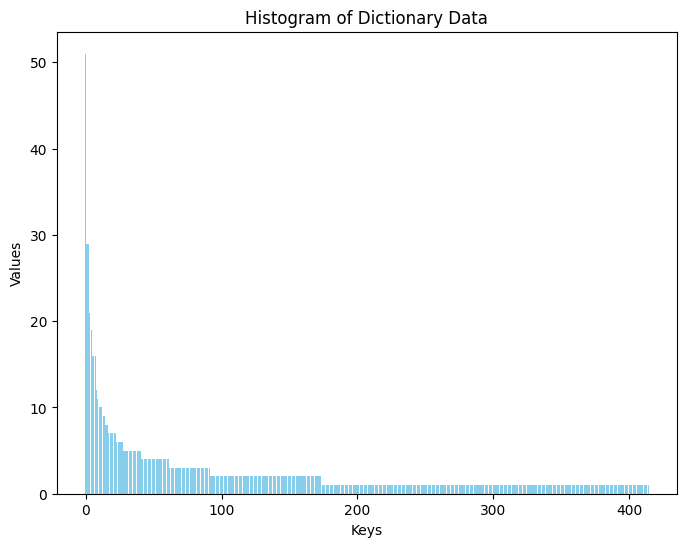

In [41]:
# Extract keys and values
keys = range(len(resnet50_concepts.keys()))
values = list(resnet50_concepts.values())

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Histogram of Dictionary Data')
plt.show()

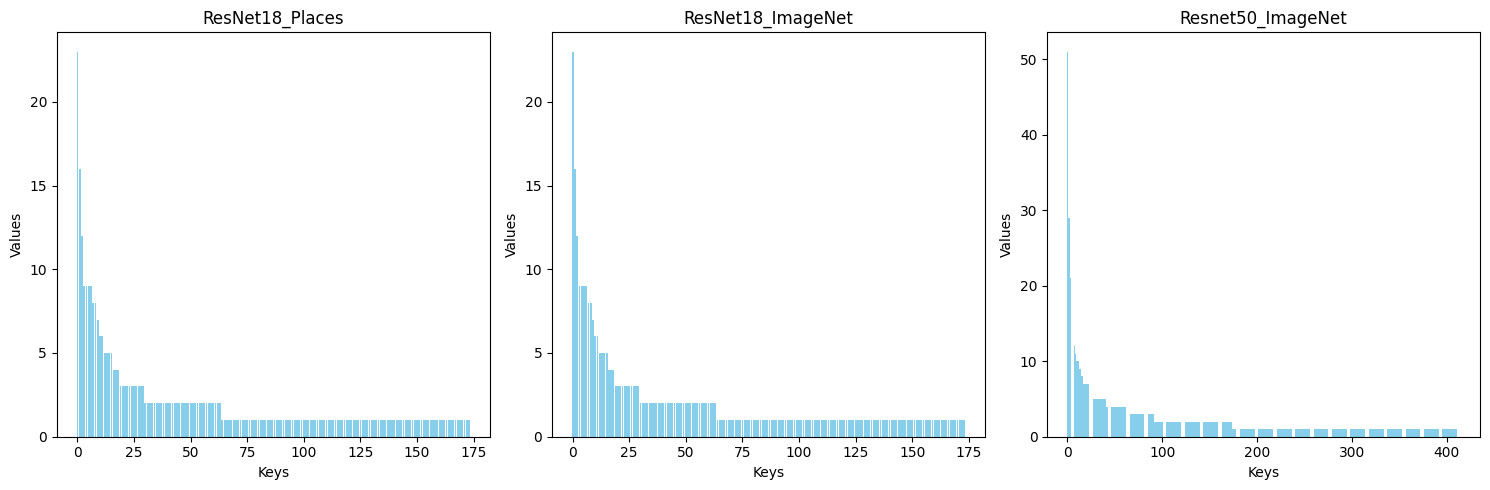

In [59]:
# List of dictionaries and corresponding subplot titles
dicts = [resnet18_places_concepts, resnet18_img_concepts, resnet50_concepts]
titles = ['ResNet18_Places', 'ResNet18_ImageNet', 'Resnet50_ImageNet']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plotting each dictionary on a separate subplot
for i, (data, title) in enumerate(zip(dicts, titles)):
    keys = range(len(data.keys()))
    values = list(data.values())
    
    axes[i].bar(keys, values, color='skyblue')
    axes[i].set_title(title)
    axes[i].set_xlabel('Keys')
    axes[i].set_ylabel('Values')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [37]:
# resnet 50 

resnet50_concepts = OrderedDict(concepts_learned.most_common())


In [49]:
resnet18_img_concepts = OrderedDict(concepts_learned.most_common())


In [56]:
resnet18_places_concepts = OrderedDict(concepts_learned.most_common())


In [39]:
resnet50_concepts.keys()

odict_keys(['dog', 'birding', 'deg', 'snorkeling', 'wildlife', 'terrier', 'insect', 'monkeys', 'lizard', 'bird', 'bedroom', 'car', 'food', 'snake', 'harbor', 'spider', 'stationery', 'coyote', 'bathroom', 'recipe', 'cub', 'kiosk', 'packaging', 'reptiles', 'knit', 'pocketpc', 'dogs', 'fruits', 'bookshop', 'basename', 'dresser', 'tractors', 'slug', 'otter', 'vehicle', 'vegetables', 'cookware', 'fish', 'clock', 'shoes', 'bookmarks', 'cobra', 'crab', 'bloodhound', 'duck', 'seafood', 'fungi', 'butterfly', 'glassware', 'saxophone', 'faucet', 'ferries', 'mushroom', 'powerpc', 'tableware', 'bicycles', 'gown', 'textile', 'ivtools', 'worldcat', 'swimwear', 'landmarks', 'pelican', 'pitcher', 'husky', 'elephants', 'beetle', 'dinner', 'retriever', 'frog', 'vendors', 'insects', 'sailing', 'birds', 'turtle', 'bag', 'percussion', 'shell', 'cookbooks', 'cordless', 'bikes', 'vehicles', 'guitar', 'armour', 'trains', 'musicians', 'gymnastics', 'erosion', 'pot', 'projectors', 'rake', 'garment', 'bookshelf',

In [54]:
# resnet 18 places

concepts_learned

Counter({'wildlife': 23,
         'bedroom': 16,
         'mosque': 12,
         'food': 9,
         'car': 9,
         'snorkeling': 9,
         'landmarks': 9,
         'ferries': 8,
         'nature': 8,
         'beverage': 7,
         'vehicles': 6,
         'erosion': 6,
         'dog': 5,
         'juvenile': 5,
         'desk': 5,
         'swings': 5,
         'bookshop': 4,
         'pasture': 4,
         'social': 4,
         'vehicle': 3,
         'foods': 3,
         'bookshelf': 3,
         'desert': 3,
         'trains': 3,
         'kitchen': 3,
         'kiosk': 3,
         'barn': 3,
         'volleyball': 3,
         'cottages': 3,
         'performances': 3,
         'insect': 2,
         'vendors': 2,
         'lighthouse': 2,
         'textile': 2,
         'tub': 2,
         'yellowstone': 2,
         'watersports': 2,
         'tractors': 2,
         'beverages': 2,
         'fauna': 2,
         'bed': 2,
         'ambulance': 2,
         'garment': 2,
         

In [55]:
# resnet 18 imagenet
concepts_learned

Counter({'wildlife': 23,
         'bedroom': 16,
         'mosque': 12,
         'food': 9,
         'car': 9,
         'snorkeling': 9,
         'landmarks': 9,
         'ferries': 8,
         'nature': 8,
         'beverage': 7,
         'vehicles': 6,
         'erosion': 6,
         'dog': 5,
         'juvenile': 5,
         'desk': 5,
         'swings': 5,
         'bookshop': 4,
         'pasture': 4,
         'social': 4,
         'vehicle': 3,
         'foods': 3,
         'bookshelf': 3,
         'desert': 3,
         'trains': 3,
         'kitchen': 3,
         'kiosk': 3,
         'barn': 3,
         'volleyball': 3,
         'cottages': 3,
         'performances': 3,
         'insect': 2,
         'vendors': 2,
         'lighthouse': 2,
         'textile': 2,
         'tub': 2,
         'yellowstone': 2,
         'watersports': 2,
         'tractors': 2,
         'beverages': 2,
         'fauna': 2,
         'bed': 2,
         'ambulance': 2,
         'garment': 2,
         

In [68]:
top_probs = max([el[3] for el in top_50_layer_tuples])

In [69]:
top_probs

0.14938354

In [70]:
top_50_layer_tuples

[('fc', 142, 'wildlife', 0.14938354),
 ('fc', 52, 'bedroom', 0.14700317),
 ('fc', 363, 'bedroom', 0.14633179),
 ('fc', 124, 'bedroom', 0.14356995),
 ('fc', 62, 'insect', 0.14224243),
 ('fc', 150, 'wildlife', 0.13961792),
 ('fc', 346, 'dog', 0.13885498),
 ('fc', 104, 'wildlife', 0.13664246),
 ('fc', 279, 'wildlife', 0.13616943),
 ('fc', 267, 'food', 0.1361084),
 ('fc', 51, 'bedroom', 0.1352539),
 ('fc', 3, 'bedroom', 0.13298035),
 ('fc', 359, 'wildlife', 0.13276672),
 ('fc', 28, 'car', 0.13227844),
 ('fc', 139, 'food', 0.13204956),
 ('fc', 36, 'wildlife', 0.13150024),
 ('fc', 148, 'food', 0.1312561),
 ('fc', 323, 'wildlife', 0.13078308),
 ('fc', 171, 'ferries', 0.13061523),
 ('fc', 224, 'wildlife', 0.13031006),
 ('fc', 345, 'insects', 0.12936401),
 ('fc', 257, 'car', 0.12902832),
 ('fc', 29, 'car', 0.12882996),
 ('fc', 114, 'food', 0.1288147),
 ('fc', 287, 'wildlife', 0.12876892),
 ('fc', 356, 'wildlife', 0.12564087),
 ('fc', 199, 'vehicle', 0.1250763),
 ('fc', 258, 'wildlife', 0.123748